# **Mean-Reverting Stochastic Process Modeling**

The goal of this project is to model a mean-reverting stochastic process and compute a few quantities that could aid in decision-making. Consider the [`spread.xlsx`](data/spread.xlsx) file, which contains a time series (in 5-minute increments) of the **spread between two assets**. This portfolio $(\text{asset}_A - \text{asset}_B)$ appears to be oscillating predictably around a mean value. A potential trading strategy would seek to buy or sell such a portfolio whenever it’s value deviates from the mean.

We assume the spread $S_t$ can be described with the following stochastic differential equation:

$$ dS_t = a(S_t,t; \theta_a)dt + b(S_t,t; \theta_b)dW_t $$

where $W_t$ is a Wiener process, and $a(s,t; \theta_a)$ and $b(s,t; \theta_b)$ are deterministic functions of $s,t$ and some parameters $\theta_a$ and $\theta_b$. One of the models that follows this form is an **Ornstein-Uhlenbeck (O-U) process**:

$$ dS_t = \alpha(\kappa - S_t)dt + \sigma dW_t $$

where: 
- $\alpha \ge 0$
- $\kappa \in \mathbb{R}$
- $\sigma \ge 0$

Note that here, we have $\theta_a = (\kappa, \alpha)$ and $\theta_b = \sigma$.

---

### **Estimating $\alpha$, $\kappa$, and $\sigma$**

We will now estimate parameters $\alpha$, $\kappa$, and $\sigma$ so that the resulting simulations closely match the spread. First, let's try to understand what these parameters represent:
- Parameter $\kappa$: is the long-term mean value of the spread. As such, the term $(\kappa - S_t)$ represents the deterministic part of the spread's change. When $S_t > \kappa$ for example, the term $(\kappa - S_t)$ is negative, which implies that the spread will decrease, reverting back to the mean value $\kappa$. In other words, the term $(\kappa - S_t)$ represents the deterministic mean-reverting force.
    - Parameter $\alpha$: controls the intensity of this deterministic mean-reverting force on the spread.
- Parameter $\sigma$: is the coefficient of the Wiener process term $dW_t$, which represents the random component of the spread's change. Indeed, parameter $\sigma$ scales the impact of these random fluctuations, and thus represents the volatility (i.e., standard deviation) of the stochastic changes in the spread.

These parameters define functions $a(S_t,t; \theta_a)$ and $b(S_t,t; \theta_b)$, which are the drift and diffusion coefficients, respectively, for the Ornstein-Uhlenbeck (O-U) process. The drift coefficient, $a(S_t,t; \theta_a)$, is tied to the deterministic component of the process, dictating the expected direction and rate of change based on the current state and parameters. It reflects how the process trends towards its mean. The diffusion coefficient, $b(S_t,t; \theta_b)$, relates to the stochastic component and modulates the influence of random fluctuations introduced by the Wiener process $dW_t$. Together, these coefficients capture the interplay between deterministic trends and stochastic dynamics in the O-U process.

With this understanding, we can now tackle the estimation. We start off with preparing the data.

##### **Data preparation and inspection**
We load the spread data, clean it, and inspect it.

In [24]:
import pandas as pd

# Load the data.
spread_df = pd.read_excel('data/spread.xlsx')

# Drop unnecessary first column.
spread_df.drop(spread_df.columns[0], axis=1, inplace=True)

# Remove null values.
spread_df.dropna(inplace=True)

# Print the data head.
print(spread_df.head())

      Spread
0  20.380000
1  20.400000
2  20.412500
3  20.418125
4  20.428125


In [25]:
# Extract spread values in a numpy array.
spreads = spread_df['Spread'].values

# Print descriptive statistics.
print(spread_df.describe())

             Spread
count  29182.000000
mean      21.707309
std        1.189484
min       17.651875
25%       20.945000
50%       21.795000
75%       22.568750
max       24.500625


##### **Parameter estimation**

We are going to estimate $\alpha$, $\kappa$, and $\sigma$ using **Maximum Likelihood Estimation** (MLE). The idea behind this method is to find the values of model parameters that maximize the likelihood function, which measures how likely the model explains the observed data. 

We start from the stochastic differential equation we saw previously:

$$ dS_t = \alpha(\kappa - S_t)dt + \sigma dW_t $$

In the context of a numerical solution, we replace the infinitesimal change $dS_t$ with a finite change $\Delta S_t$. The formula becomes:

$$
\begin{align*}

\Delta S_t &= S_{t + \Delta t} - S_t \\&\approx \alpha(\kappa - S_t)\Delta t + \sigma \sqrt{\Delta t}\;\epsilon 

\end{align*}
$$

where $\epsilon$ is a random sample from a standard normal distribution, $N(0,1)$. 
- The intuition behind the stochastic component of the expression above is based on statistical theory, which says that if the variance of random variable $X$ is $\sigma^2$, then the variance of $c X$ is $c^2 \sigma^2$, where $c$ is a constant.
- In our case, we need a variance of $\sigma^2 \Delta t$. So if our random variable $\epsilon$ is sampled from $N(0,1)$, then we need to multiply $\epsilon$ with $\sigma \sqrt{\Delta t}$.

As stated previously, we need to construct the likelihood function, which represents the probability of observing a specific sequence of spread changes given the parameters $\alpha$, $\kappa$, and $\sigma$. This can be computed as:

$$L(\Delta S_t | \alpha, \kappa, \sigma) = \prod_{t=1}^{n-1} p(\Delta S_t | \alpha, \kappa, \sigma)$$

Indeed, the likelihood of observing the entire sequence of spread changes is the product of the probabilities of observing each individual spread change $\Delta S_t$, given the model parameters. Because we are dealing with a *continuous* random variable $S_t$, we compute $p$ with a probability density function (PDF) rather than a probability distribution. Furthermore, because S_t is defined by a stochastic component that adheres to a normal distribution, we will compute $p$ using the formula of a PDF for a normal distribution. The formula goes:

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \Big(- \frac{(x - \mu)^2}{2 \sigma^2} \Big)$$

where $x$ is the continuous random variable, $\mu$ is the mean, and $\sigma^2$ is the variance. Now, recall that in our case:
- mean = $\alpha(\kappa - S_t)dt$
- variance = $\sigma^2 \Delta t$

Substituting our own mean and variance definition inside the PDF formula above, we get:
$$p(\Delta S_t | \alpha, \kappa, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2 \Delta t}}\exp \Big(- \frac{(\Delta S_t - \alpha(\kappa - S_t) \Delta t)^2}{2 \sigma^2 \Delta t} \Big)$$

We can now obtain the likelihood function. However, taking the *logarithm* of the likelihood function simplifies the multiplication into a sum, making it easier to handle, especially for computational purposes. The log-likelihood ($\log L$) in our case can be written as:

$$
\begin{align*}

\log L(\Delta S_t | \alpha, \kappa, \sigma) &= \sum_{t=1}^{n-1} \log p(\Delta S_t | \alpha, \kappa, \sigma) \\&= \sum_{t=1}^{n-1} \Big[ -\frac{1}{2} \log (2 \pi \sigma^2 \Delta t) - \frac{(\Delta S_t - \alpha(\kappa - S_t) \Delta t)^2}{2 \sigma^2 \Delta t} \Big]

\end{align*}
$$

We implement this log-likelihood function and the optimization function below:

In [26]:
import numpy as np
from typing import Callable

def ou_negative_log_likelihood(params: list[float], 
                               spreads: np.ndarray, 
                               dt: float, 
                               mu_func: Callable, 
                               var_func: Callable) -> float:
    """
    Computes the negative log-likelihood for a general O-U process on a 
    given dataset, given the set of parameters and functions to calculate
    mu and var.

    Arguments
    ---------
    params   :  The list of O-U process parameters.
    spreads  :  The spreads data.
    dt       :  The time step size.
    mu_func  :  A function to calculate the expected mean.
    var_func :  A function to calculate the variance.

    Returns
    -------
    -log_likelihood :  The negative log-likelihood.
    
    """
    # Define the spread and spread change.
    S_t = spreads[:-1]
    dS_t = np.diff(spreads)

    # Calculate the expected mean and variance using the provided functions.
    mu = mu_func(params, S_t, dt)
    var = var_func(params, S_t, dt)

    # Calculate the log-likelihood.
    log_likelihood = np.sum(
        -1/2 * np.log(2 * np.pi * var) - (dS_t - mu) ** 2 / (2 * var)
    )

    return -log_likelihood

def ou_drift_coeff(params: list[float], 
                   S_t: np.ndarray, 
                   dt: float) -> float:
    """
    Computes the drift coefficient of the O-U process. This coefficient
    is tied to the deterministic mean-reverting component of the O-U process. 

    Arguments
    ---------
    params :  The list of O-U process parameters (alpha, kappa, sigma).
    S_t    :  The series of spread values.
    dt     :  The time step size.

    Returns
    -------
    drift :  The drift coefficient for the O-U process.

    """
    alpha, kappa, sigma = params
    drift = alpha * (kappa - S_t) * dt

    return drift

def ou_diffusion_coeff(params: list[float], 
                       S_t: np.ndarray, 
                       dt: float) -> float:
    """
    Computes the diffusion coefficient of the O-U process. This coefficient
    is tied to the stochastic component of the O-U process. 

    Arguments
    ---------
    params :  The list of O-U process parameters (alpha, kappa, sigma).
    S_t    :  The series of spread values.
    dt     :  The time step size.

    Returns
    -------
    diffusion :  The diffusion coefficient for the O-U process.

    """
    alpha, kappa, sigma = params
    diffusion = sigma ** 2 * dt

    return diffusion

In [27]:
from scipy.optimize import minimize

def run_optimization(spreads: np.ndarray, 
                     initial_params: list[float], 
                     mu_func: Callable, 
                     var_func: Callable,
                     param_names: list[str] = ["alpha", "kappa", 
                                               "sigma", "gamma", 
                                               "phi", "psi", 
                                               "omega"]) -> np.ndarray:
    """
    Runs the optimization process of minimizing the negative log-likelihood
    of the O-U process given the spreads data.

    Arguments
    ---------
    spreads        :  The original spreads data.
    initial_params :  The list of initial O-U process parameter guesses.

    Returns
    -------
    result.x :  The estimated parameter values.

    """
    # Determine dt.
    steps = spread_df.describe().loc['count'].item()
    dt = 1 / steps

    # Define parameter bounds (i.e., positive parameter values).
    bounds = [(None, None)] * len(initial_params)

    # Minimize the negative log-likelihood.
    result = minimize(ou_negative_log_likelihood, 
                      initial_params, 
                      args=(spreads, dt, mu_func, var_func), 
                      bounds=bounds)

    # Print the optimization status.
    print('Optimization:')
    print(f'* Success: {result.success} ({result.message})')

    # Print the estimated parameters.
    print('\nEstimations:')
    for i in range(len(result.x)):
        print(f'* {param_names[i]} = {result.x[i]}')

    return result.x

We now run the optimization process and obtain our parameter values:

In [28]:
# Set initial parameters.
init_alpha = 1.0
init_kappa = np.mean(spreads)
init_sigma = np.std(spreads)
initial_params = [init_alpha, init_kappa, init_sigma]

# Run the parameter optimization.
params = run_optimization(spreads,
                          initial_params,
                          mu_func=ou_drift_coeff, 
                          var_func=ou_diffusion_coeff)

Optimization:
* Success: True (CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH)

Estimations:
* alpha = 29.029643674295134
* kappa = 21.76644715848241
* sigma = 8.971660672718015


---

### **Simulating realizations**

We will simulate realizations of the process using the **Euler-Maruyama method**. This method is well-suited for simulating stochastic differential equations like the Ornstein-Uhlenbeck process. It is simple, intuitive, computationally efficient, sufficiently accurate, and applicable to a wide range of equations.

The method goes as follows. Consider a stochastic differential equation of the form:

$$
dX_t = a(X_t, t)dt + b(X_t, t)dW_t
$$

The formula for the Euler-Maruyama method given this equation is:

$$
X_{t+\Delta t} = X_t + a(X_t, t)\Delta t + b(X_t, t)\Delta W_t
$$

where:
- $X_t$ is the state variable at time $t$.
- $a(X_t, t)$ is the drift coefficient.
- $b(X_t, t)$ is the diffusion coefficient.
- $\Delta t$ is a small time increment.
- $\Delta W_t$ is the increment of a Wiener process.

Applying this method to our case, this means we compute the spread at each step as follows:

$$
S_{t+\Delta t} = S_t + \alpha(\kappa - S_t)\Delta t + \sigma\sqrt{\Delta t}\;\epsilon
$$

We implement this method as follows:

In [29]:
def simulate_ou_process(params: list[float], 
                        realizations: int, 
                        s0: float, 
                        dt: float, 
                        drift_func: Callable, 
                        diffusion_func: Callable,
                        T: float = 1.0, 
                        seed: int = 42, 
                        level_threshold: float = None) -> tuple[np.ndarray, 
                                                                np.ndarray]:
    """
    Simulates path realizations of an O-U process, given its parameters. 
    This is achieved according to the Euler-Maruyama method.

    Arguments
    ---------
    params          :  The list of O-U process parameters (alpha, kappa, sigma).
    realizations    :  The number of paths to simulate.
    s0              :  The starting point.
    dt              :  The time step size.
    drift_func      :  The function to calculate the drift term.
    diffusion_func  :  The function to calculate the diffusion term.
    T               :  The total time span.
    seed            :  The random seed, for reproducibility.
    level_threshold :  The spread level threshold. Simulated paths that cross 
                       this threshold are tracked.
    Returns
    -------
    simulated_paths    :  The list of simulated O-U process paths.
    steps_to_threshold :  An array with the amount of steps each path needs 
                          to reach the level threshold.

    """
    # Prepare simulation.
    N = int(T / dt)     # number of steps
    if seed:
        np.random.seed(seed)
    simulated_paths = np.empty((N, realizations))
    simulated_paths[:] = np.nan
    simulated_paths[0, :] = s0
    steps_to_threshold = [None] * realizations

    # Simulate the realizations.
    for i in range(1, N):
        epsilon = np.random.normal(0, 1, realizations)
        simulated_paths[i, :] = simulated_paths[i-1, :] \
                                + drift_func(params, simulated_paths[i-1, :], dt) \
                                + np.sqrt(diffusion_func(params, 
                                                         simulated_paths[i-1, :], 
                                                         dt)) * epsilon
        
        if level_threshold is not None:
            # Track which simulated paths have crossed the given threshold.
            for j in range(realizations):
                if steps_to_threshold[j] is None:  # only check paths that haven't crossed yet
                    if (s0 <= level_threshold and level_threshold <= simulated_paths[i, j]) or \
                       (s0 >= level_threshold and level_threshold >= simulated_paths[i, j]):
                        steps_to_threshold[j] = i
    
    steps_to_threshold = np.array(steps_to_threshold)

    return simulated_paths, steps_to_threshold

In [30]:
import matplotlib.pyplot as plt

def plot_simulations(spreads: np.ndarray, 
                     simulated_paths: np.ndarray, 
                     realizations: int, 
                     dt: float, 
                     T: float = 1.0) -> None:
    """
    Plots the simulated path realizations of an O-U process, 
    and the original spreads data.

    Arguments
    ---------
    spreads         :  The original spreads data.
    simulated_paths :  The simulated path realizations.
    realizations    :  The number of paths to simulate.
    dt              :  The time step size.
    T               :  The total time span.
    
    """
    # Plot the simulated realizations.
    N = int(T / dt)
    plt.figure(figsize=(10, 4))
    for i in range(realizations):
        plt.plot(np.arange(N) * dt, simulated_paths[:, i], 
                 lw=0.5, label=f'Simulated Spread ({i+1})')

    # Plot the original spread data for comparison.
    plt.plot(np.linspace(0, T, len(spreads)), spreads, 
             color='black', label='Original Spread')
    plt.title('Simulated Ornstein-Uhlenbeck Processes vs. Original Spread', 
              fontweight='bold')
    plt.xlabel('Time', fontweight='bold')
    plt.ylabel('Spread', fontweight='bold')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.show()

We now run and plot a few simulations as follows:

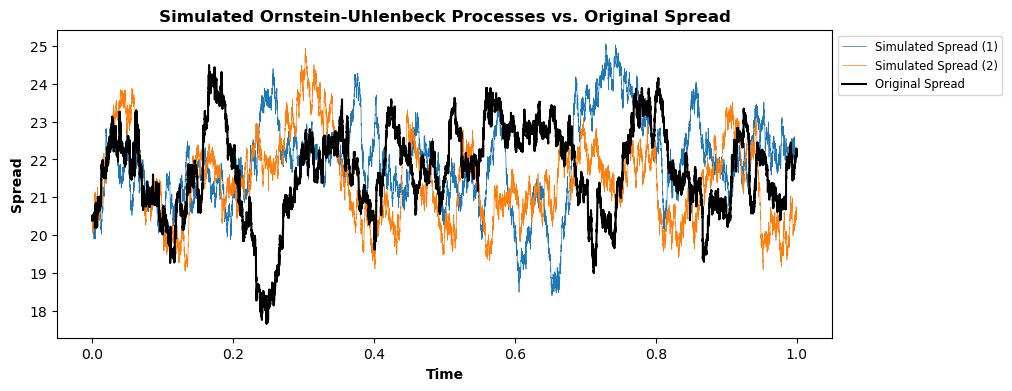

In [31]:
# Set parameters
realizations = 2    # we limit ourselves to 2 realizations for visual clarity
s0=spreads[0]
steps = spread_df.describe().loc['count'].item()
dt = 1 / steps

# Run and plot the simulations
simulated_paths, _ = simulate_ou_process(params,
                                         realizations,
                                         s0,
                                         dt,
                                         drift_func=ou_drift_coeff,
                                         diffusion_func=ou_diffusion_coeff)

plot_simulations(spreads, simulated_paths, realizations, dt)

---

### **Computing statistical moments**

We compute a few statistical moments (i.e., the mean, variance, etc.) of the paths we simulated and compare them with the moments of the spread data:

In [32]:
def relative_difference(original: float, simulated: float) -> float:
    """
    Computes the relative difference between two given values. 
    
    In our setting, one value is associated with the original spreads data, 
    and the other is associated with a simulated spread path.

    """
    return abs(original - simulated) / abs(original) * 100

In [33]:
from scipy.stats import skew, kurtosis

def print_moments(spreads_data: np.ndarray, 
                  simulated_data: np.ndarray, 
                  data_type: str) -> None:
    """
    Computes and prints statistical moments and relative differences 
    between original spread data and simulated data.

    Arguments
    ---------
    spreads_data   :  The data associated with the original spreads.
    simulated_data :  The data assocaited with the simulated paths.
    data_type      :  The kind of data we are dealing with in string form,
                      e.g. 'Paths' or 'Increments'.

    """
    # Compute the moments for original spread data.
    spreads_data_mean = np.mean(spreads_data)
    spreads_data_var = np.var(spreads_data)
    spreads_data_skew = skew(spreads_data)
    spreads_data_kurt = kurtosis(spreads_data)

    # Compute the moments for simulated paths.
    simulated_data_mean = np.mean(np.mean(simulated_data, axis=0))
    simulated_data_var = np.mean(np.var(simulated_data, axis=0))
    simulated_data_skew = np.mean(skew(simulated_data, axis=0))
    simulated_data_kurt = np.mean(kurtosis(simulated_data, axis=0))

    relative_difference_mean = relative_difference(spreads_data_mean, simulated_data_mean)
    relative_difference_var = relative_difference(spreads_data_var, simulated_data_var)
    relative_difference_skew = relative_difference(spreads_data_skew, simulated_data_skew)
    relative_difference_kurt = relative_difference(spreads_data_kurt, simulated_data_kurt)

    # Print the moments.
    print(f'Spread {data_type} Moments')
    print('-' * (len(data_type) + 15))
    print(f'Mean: {spreads_data_mean}')
    print(f'Variance: {spreads_data_var}')
    print(f'Skew: {spreads_data_skew}')
    print(f'Kurtosis: {spreads_data_kurt}\n')

    print(f'Simulated {data_type} Moments (average)')
    print('-' * (len(data_type) + 28))
    print(f'Mean: {simulated_data_mean}')
    print(f'Variance: {simulated_data_var}')
    print(f'Skew: {simulated_data_skew}')
    print(f'Kurtosis: {simulated_data_kurt}\n\n')

    print('Relative Difference')
    print('-------------------')
    print(f'Mean: {relative_difference_mean:.2f}%')
    print(f'Variance: {relative_difference_var:.2f}%')
    print(f'Skew: {relative_difference_skew:.2f}%')
    print(f'Kurtosis: {relative_difference_kurt:.2f}%')

In [34]:
# Run more simulations.
realizations = 1000
simulated_paths, _ = simulate_ou_process(params,
                                         realizations,
                                         s0,
                                         dt,
                                         drift_func=ou_drift_coeff,
                                         diffusion_func=ou_diffusion_coeff)

# Compute and print the moments.
print_moments(spreads, simulated_paths, data_type='Paths')

Spread Paths Moments
--------------------
Mean: 21.707308807655405
Variance: 1.4148241583285703
Skew: -0.5474354025181073
Kurtosis: 0.39893613722928967

Simulated Paths Moments (average)
---------------------------------
Mean: 21.714855312583975
Variance: 1.3175120006061782
Skew: 0.01639404292614005
Kurtosis: -0.18238607427533032


Relative Difference
-------------------
Mean: 0.03%
Variance: 6.88%
Skew: 102.99%
Kurtosis: 145.72%


Based on relative difference calculations, we conclude that the O-U model fits the spread data very well in terms of the mean, and decently in terms of the variance, but poorly in terms of skewness and kurtosis. We observe that as the order of the moment increases, the model's performance worsens with respect to that moment.

---

### **Customizing the O-U process**

We will now try to come up with our own functional form for $a(S_t,t; \theta_a)$ and $b(S_t,t; \theta_b)$. We saw previously that the O-U process we have is good at modeling the spread data with respect to the mean and variance. However, the higher-order moments such as the skewness and the kurtosis are off. To mitigate this, we will create a customized O-U process model. We will attempt to increase the complexity of the drift and diffusion coefficients $a(S_t,t; \theta_a)$ and $b(S_t,t; \theta_b)$ such that the expressiveness of the model is increased, which will hopefully allow for a better fit of higher-order dynamics in the data.

</br>

**The custom drift coefficient**: 

We add a quadratic term tied to a new parameter $\gamma$, resulting in the following expression:

$$
a(S_t,t; \theta_a) = \alpha(\kappa - S_t)dt + \gamma(\kappa - S_t)^2 dt
$$

This extra term represents a higher-order force that either strengthens or weakens the mean reversion as the spread deviates further from $\kappa$.

</br>

**The custom drift coefficient**: 

We consider a base level of volatility $\sigma$, and an additional term tied to a new parameter $\phi$ that scales with the absolute spread difference. 

$$
b(S_t,t; \theta_b) = (\sigma + \phi|\kappa - S_t|)^2 dt
$$

This way, the model accounts for variable volatility. This approach recognizes that market volatility might not be constant, and could escalate as the spread diverges more significantly from its long-term average.

</br>

The implementation of these coefficients can be found below:

In [35]:
def custom_ou_drift_coeff(params: list[float], 
                          S_t: np.ndarray, 
                          dt: float) -> float:
    """
    Computes the drift coefficient of the O-U process. This coefficient
    is tied to the deterministic mean-reverting component of the O-U process. 

    Arguments
    ---------
    params :  The list of custom O-U process parameters 
              (alpha, kappa, gamma, sigma, phi).
    S_t    :  The series of spread values.
    dt     :  The time step size.

    Returns
    -------
    drift :  The drift coefficient for the custom O-U process.
       
    """
    alpha, kappa, sigma, gamma, phi = params
    drift = alpha * (kappa - S_t) * dt + gamma * (kappa - S_t) ** 2 * dt

    return drift

def custom_ou_diffusion_coeff(params: list[float], 
                              S_t: np.ndarray, 
                              dt: float) -> float:
    """
    Computes the diffusion coefficient of the O-U process. This coefficient
    is tied to the stochastic component of the O-U process. 

    Arguments
    ---------
    params :  The list of custom O-U process parameters 
              (alpha, kappa, gamma, sigma, phi).
    S_t    :  The series of spread values.
    dt     :  The time step size.

    Returns
    -------
    diffusion :    The diffusion coefficient for the custom O-U process.

    """
    alpha, kappa, sigma, gamma, phi = params
    diffusion = (sigma + phi * np.abs(kappa - S_t)) ** 2 * dt

    return diffusion

---

### **Estimating $\alpha$, $\kappa$, $\gamma$, $\sigma$, and $\phi$**

We now estimate the parameters of our own functional form so that simulations of the resulting process closely matches the spread. We use the Euler-Maruyama method we have already seen previously:

In [36]:
# Set initial parameters.
init_alpha = 1
init_kappa = np.mean(spreads)
init_gamma = 1
init_sigma = np.std(spreads)
init_phi = 1
initial_params = [init_alpha, init_kappa, init_gamma, init_sigma, init_phi]

# Run the parameter optimization.
params = run_optimization(spreads,
                          initial_params,
                          mu_func=custom_ou_drift_coeff, 
                          var_func=custom_ou_diffusion_coeff)

Optimization:
* Success: True (CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH)

Estimations:
* alpha = 22.78572626626523
* kappa = 21.251836318585926
* sigma = 8.30017975284046
* gamma = -1.6014984422322527
* phi = 0.6393633634895782


We now run and plot a few simulations:

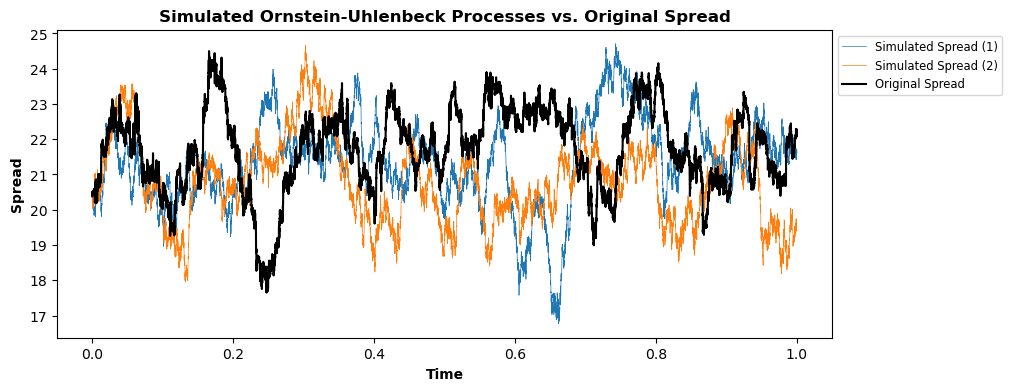

In [37]:
realizations = 2    # we limit ourselves to 2 realizations for visual clarity
s0 = spreads[0]

# Run and plot the simulations.
simulated_paths, _ = simulate_ou_process(params,
                                         realizations,
                                         s0,
                                         dt,
                                         drift_func=custom_ou_drift_coeff,
                                         diffusion_func=custom_ou_diffusion_coeff)

plot_simulations(spreads, simulated_paths, realizations, dt)

---

### **Performance assessment**

Just like before, we assess the performance of the customized O-U process model by computing the average statistical moments of the simulated paths:

In [38]:
# Run more simulations.
realizations = 1000
simulated_paths, _ = simulate_ou_process(params,
                                         realizations,
                                         s0,
                                         dt,
                                         drift_func=custom_ou_drift_coeff,
                                         diffusion_func=custom_ou_diffusion_coeff)

# Compute and print moments.
print_moments(spreads, simulated_paths, data_type='Paths')

Spread Paths Moments
--------------------
Mean: 21.707308807655405
Variance: 1.4148241583285703
Skew: -0.5474354025181073
Kurtosis: 0.39893613722928967

Simulated Paths Moments (average)
---------------------------------
Mean: 21.082776425685804
Variance: 1.6962972945007888
Skew: -0.14094614294745111
Kurtosis: 0.1422512235590848


Relative Difference
-------------------
Mean: 2.88%
Variance: 19.89%
Skew: 74.25%
Kurtosis: 64.34%


The results show that the relative differences of the two models are as follows:

| Metric             | O-U Process       | Customized O-U Process |
|--------------------|-------------------|------------------------|
| Mean               | 0.03%             | 2.88%                  |
| Variance           | 6.88%             | 19.89%                 |
| Skewness           | 102.99%           | 74.25%                 |
| Kurtosis           | 145.72%           | 64.34%                 |

We see that the customized O-U process doesn't model the data as well with respect to the mean and variance, but offers a significant improvement with respect to the skewness and kurtosis. 

---

### **Computing level expectations**

Using these models, we can now compute expectations that can help in decision-making. We will now write a function that can compute the conditional expectation of the spread reaching a certain **level** (e.g the long term average) in a given amount of time T (e.g 30 periods) from a chosen starting point. We can then plot the density of terminal values to visualize the result.

To achieve this, we employ a Monte Carlo simulation approach. This method involves simulating multiple paths of the O-U process and calculating the mean of all terminal values.

In [39]:
def get_conditional_expectation(params: list[float], 
                                T: float, 
                                s0: float, 
                                dt: float, 
                                realizations: int, 
                                drift_func: Callable, 
                                diffusion_func: Callable) -> tuple[np.ndarray, float]:
    """
    Computes the conditional expectation and the terminal values of the spread 
    in a given amount of time from a given starting point, where the spread is 
    modeled by an O-U process.

    Arguments
    ---------
    params         :  The list of O-U process parameters.
    T              :  The time span of the simulation.
    s0             :  The starting point.
    dt             :  The time step size.
    drift_func     :  The function to calculate the drift term.
    diffusion_func :  The function to calculate the diffusion term.
    realizations   :  The number of paths to simulate.

    Returns
    -------
    terminal_levels :  The terminal level values of the simulated paths.
    expected_level  :  The conditional expectation of the spread level.

    """
    # Generate paths.
    simulated_paths, _ = simulate_ou_process(params,
                                             realizations,
                                             s0,
                                             dt,
                                             drift_func,
                                             diffusion_func,
                                             T)
    
    # Get the terminal level values and compute the expected spread level value.
    terminal_levels = simulated_paths[-1, :]
    expected_level = np.mean(terminal_levels)
    
    return terminal_levels, expected_level

Let's run an example:

In [40]:
# Set parameters.
kappa_est = params[1]
T = 0.05
days = T * steps / (12 * 24)    # time in days
s0 = kappa_est * 0.85
realizations = 1000

# Compute the expected level and terminal level values.
terminal_levels, expected_level = get_conditional_expectation(params,
                                                              T,
                                                              s0,
                                                              dt,
                                                              realizations,
                                                              drift_func=custom_ou_drift_coeff,
                                                              diffusion_func=custom_ou_diffusion_coeff)


# Print the result
print(f'The conditional expectation of the spread level over a {days:.2f} day period ' +
      f'starting from ${s0:.2f} is: ${expected_level:.2f}.')

The conditional expectation of the spread level over a 5.07 day period starting from $18.06 is: $19.85.


We can now plot the density of these levels:

In [41]:
import seaborn as sns
import warnings

def plot_terminal_level_densities(terminal_levels: np.ndarray) -> None:
    """
    Plots the terminal level densities of given terminal level values of paths.

    """
    # Suppress the FutureWarning.
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Plot the density of terminal values.
    plt.figure(figsize=(10, 4))
    sns.kdeplot(terminal_levels, bw_adjust=0.5, fill=True)
    plt.title('Density of the Terminal Levels of the Spread', fontweight='bold')
    plt.xlabel('Spread Value', fontweight='bold')
    plt.ylabel('Density', fontweight='bold')
    plt.show()

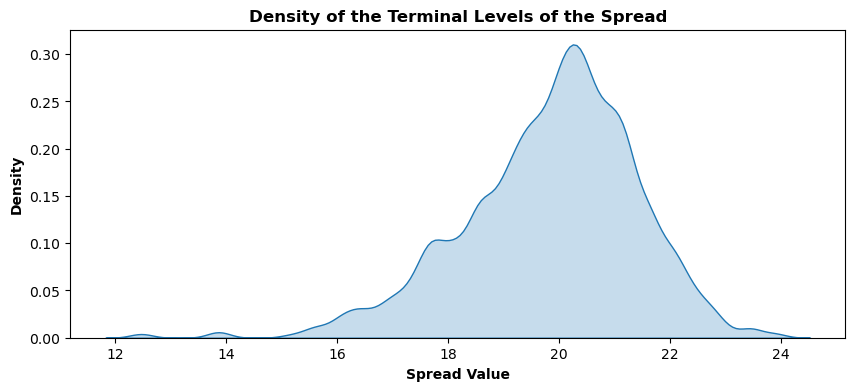

In [42]:
plot_terminal_level_densities(terminal_levels)

---

### **Computing time expectations**

Previously, we computed the expectation w.r.t. the level of the spread. We could also compute the expected **time** (number of periods) it takes for the process to hit a certain level (e.g the long term average) from a given starting point. 

We employ the same approach as before, that is, a Monte Carlo approach. We repeatedly generate random paths and track the time it takes for each path to hit the desired target level. Using this data, we can calculate the expected time.

In [43]:
def get_expected_time(params: list[float], 
                      level: float, 
                      s0: float, 
                      dt: float, 
                      realizations: int, 
                      drift_func: Callable, 
                      diffusion_func: Callable) -> tuple[float, np.ndarray]:
    """
    Computes the expected time for the spread to reach a given level from 
    a given starting point, where the spread is modeled by an O-U process.
    The terminal values for each path are also returned.

    Arguments
    ---------
    params       :  The list of O-U process parameters.
    level        :  The threshold level to be reached by the simulated spread path.
    s0           :  The starting point.
    dt           :  The time step size.
    realizations :  The number of paths to simulate.

    Returns
    -------
    days               :  The expected time (in days).
    steps_to_threshold :  The array of time steps until the threshold is reached.
    
    """
    # Generate paths.
    _, steps_to_threshold = simulate_ou_process(params,
                                                realizations,
                                                s0,
                                                dt,
                                                drift_func,
                                                diffusion_func,
                                                level_threshold=level)

    # Compute the expected time in days.
    mean_steps_to_threshold = np.mean(steps_to_threshold)
    days = mean_steps_to_threshold / (12 * 24)

    return days, steps_to_threshold

Let's run an example:

In [44]:
# Set parameters.
level = kappa_est
s0 = level * 0.85
realizations = 1000

# Compute the expected time.
days, steps_to_threshold = get_expected_time(params,
                                             level,
                                             s0,
                                             dt,
                                             realizations,
                                             drift_func=custom_ou_drift_coeff,
                                             diffusion_func=custom_ou_diffusion_coeff)


# Print the result.
print(f'The expected time of the spread reaching ${level:.2f} ' +
      f'starting from ${s0:.2f} is: {days:.2f} days.')

The expected time of the spread reaching $21.25 starting from $18.06 is: 8.20 days.


We can now plot the density of these times:

In [45]:
def plot_terminal_time_densities(steps_to_threshold):
    """
    Plots the terminal time densities given an array of the number of steps to reach
    the terminal level threshold for each path.
    
    """
    # Suppress the FutureWarning.
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Compute the time in days based on the the given steps.
    days_to_threshold = steps_to_threshold / (12 * 24)

    # Plot the density of terminal values.
    plt.figure(figsize=(10, 4))
    sns.kdeplot(days_to_threshold, bw_adjust=0.5, fill=True)
    plt.title('Density of the Terminal Times of the Spread Paths', fontweight='bold')
    plt.xlabel('Time (days)', fontweight='bold')
    plt.ylabel('Density', fontweight='bold')
    plt.xlim(0)
    plt.show()

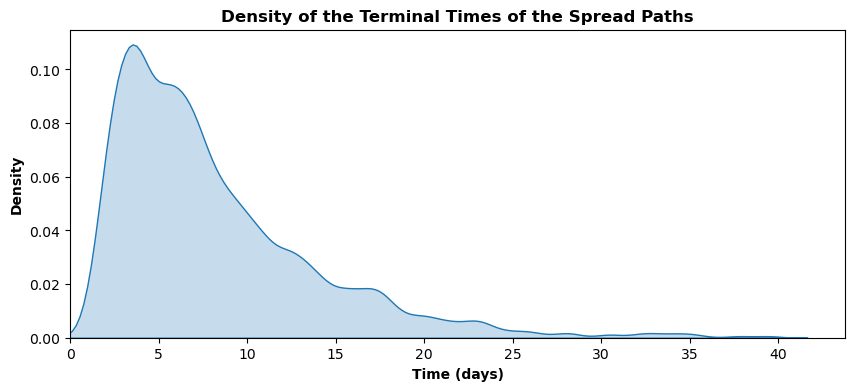

In [46]:
plot_terminal_time_densities(steps_to_threshold)

---